<h2 align="center">Automatic Machine Learning with H2O AutoML</h2>

In [13]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [14]:
#load data
xls = pd.ExcelFile('bank_term_deposit_marketing_analysis.xlsx')

In [15]:
#check out all the sheets
xls.sheet_names

['PROCEDURE',
 'DATA DESCRIPTION',
 'Step 1 - Collect Information',
 'CLIENT_INFO',
 'LOAN_HISTORY',
 'MARKETING HISTORY',
 'SUBSCRIPTION HISTORY',
 'Step 2 - Merge Information',
 'CLIENT_MERGE',
 'Step 3 - Marketing Analysis',
 'DAILY RANGE',
 'JOB ANALYSIS',
 'Sheet3']

In [16]:
#select only sheets that we want
#create seperate dataframe for each sheet
client_info = pd.read_excel(xls, 'CLIENT_INFO')
loan_history = pd.read_excel(xls, 'LOAN_HISTORY')
marketing_history = pd.read_excel(xls, 'MARKETING HISTORY')
subscription_history = pd.read_excel(xls, 'SUBSCRIPTION HISTORY')

In [17]:
#preview
client_info.head()

,ID,AGE,JOB,MARITAL,EDUCATION
0,2836,58,management,married,tertiary
1,2837,44,technician,single,secondary
2,2838,33,entrepreneur,married,secondary
3,2839,47,blue-collar,married,unknown
4,2840,33,unknown,single,unknown


In [18]:
#preview
loan_history.head()

,ID,DEFAULT,BALANCE,HOUSING,LOAN
0,2836,no,2143,yes,no
1,2837,no,29,yes,no
2,2838,no,2,yes,yes
3,2839,no,1506,yes,no
4,2840,no,1,no,no


In [19]:
#preview
marketing_history.head()

,ID,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME
0,2836,unknown,5,may,261,1,-1,0,unknown
1,2837,unknown,5,may,151,1,-1,0,unknown
2,2838,unknown,5,may,76,1,-1,0,unknown
3,2839,unknown,5,may,92,1,-1,0,unknown
4,2840,unknown,5,may,198,1,-1,0,unknown


In [20]:
#preview
subscription_history.head()

#no = client did not enroll
#yes = client enrolled
#binary classification problem

,ID,TERM_DEPOSIT
0,2836,no
1,2837,no
2,2838,no
3,2839,no
4,2840,no


In [21]:
#combine dataframe
df = pd.merge(client_info, loan_history, on=['ID'])
df = pd.merge(df, marketing_history, on=['ID'])
df = pd.merge(df, subscription_history, on=['ID'])

#preview
df.head()

,ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
0,2836,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2837,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2838,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,2839,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,2840,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [22]:
#drop 'ID' since it is not predictive
df = df.drop(columns=['ID'], axis=1)
df.head()

,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [45]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   AGE           45211 non-null  int64 
 1   JOB           45211 non-null  object
 2   MARITAL       45211 non-null  object
 3   EDUCATION     45211 non-null  object
 4   DEFAULT       45211 non-null  object
 5   BALANCE       45211 non-null  int64 
 6   HOUSING       45211 non-null  object
 7   LOAN          45211 non-null  object
 8   CONTACT       45211 non-null  object
 9   DAY           45211 non-null  int64 
 10  MONTH         45211 non-null  object
 11  DURATION      45211 non-null  int64 
 12  CAMPAIGN      45211 non-null  int64 
 13  PDAYS         45211 non-null  int64 
 14  PREVIOUS      45211 non-null  int64 
 15  POUTCOME      45211 non-null  object
 16  TERM_DEPOSIT  45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


## Data Prep & Start H2O

In [24]:
#start H2O cluster
! pip install h2o
import h2o

#initialize
h2o.init()

     |████████████████████████████████| 168.4 MB 69 kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.6-py2.py3-none-any.whl size=168439194 sha256=20e027b37c9f959849ac2cc3f54d2d3c1efce1403ac9570fdefb6a1964284ec8
  Stored in directory: /root/.cache/pip/wheels/ee/0f/51/849ba221c4c1b11a04efb4a3427dc9cb1c4dcde218c6c98b13
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk_45873o
  JVM stdout: /tmp/tmpk_45873o/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpk_45873o/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.6
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_ypkmys
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [25]:
#convert pandas df into h2o frame
h2o_df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [26]:
#preview
h2o_df.head()

AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [27]:
#statistics
h2o_df.describe()

#enum ~ categorical data

Rows:45211
Cols:17




,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
type,int,enum,enum,enum,enum,int,enum,enum,enum,int,enum,int,int,int,int,enum,enum
mins,18.0,,,,,-8019.0,,,,1.0,,0.0,1.0,-1.0,0.0,,
mean,40.93621021432807,,,,,1362.2720576850802,,,,15.806418791886923,,258.16307978146915,2.7638406582468997,40.19782796222158,0.5803233726305561,,
maxs,95.0,,,,,102127.0,,,,31.0,,4918.0,63.0,871.0,275.0,,
sigma,10.618762040975398,,,,,3044.7658291685216,,,,8.32247615304459,,257.52781226517124,3.0980208832791805,100.12874599059822,2.303441044931215,,
zeros,0,,,,,3514,,,,0,,3,0,0,36954,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown,no
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown,no


In [29]:
#split train and test sets
train, test = h2o_df.split_frame(ratios=[.75])

#define X and y
X = train.columns
y = 'TERM_DEPOSIT'
X.remove(y)

In [30]:
X

['AGE',
 'JOB',
 'MARITAL',
 'EDUCATION',
 'DEFAULT',
 'BALANCE',
 'HOUSING',
 'LOAN',
 'CONTACT',
 'DAY',
 'MONTH',
 'DURATION',
 'CAMPAIGN',
 'PDAYS',
 'PREVIOUS',
 'POUTCOME']

In [31]:
y

'TERM_DEPOSIT'

## Run H2O AutoML

In [32]:
#check class distribution
df.TERM_DEPOSIT.value_counts()

no     39922
yes     5289
Name: TERM_DEPOSIT, dtype: int64

In [33]:
from h2o.automl import H2OAutoML

#initialize
aml = H2OAutoML(max_runtime_secs=600,   #keep runtime at 10mins
                balance_classes=True,
                stopping_metric='logloss',
                seed=1,
                project_name='Final') 

In [37]:
#train
%time 
aml.train(x=X, 
          y=y,
          training_frame=train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
AutoML progress: |████████████████████████████████████████████████████████| 100%


## AutoML Leaderboard and Ensemble Exploration

In [38]:
#view leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows) #show all the rows

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210902_083137,0.935697,0.195455,0.623268,0.176,0.248141,0.0615737
StackedEnsemble_BestOfFamily_AutoML_20210902_083137,0.933657,0.197893,0.618127,0.173253,0.249452,0.0622261
GBM_grid__1_AutoML_20210902_083137_model_1,0.933163,0.199264,0.612205,0.176116,0.250663,0.0628319
GBM_grid__1_AutoML_20210902_083137_model_2,0.9303,0.209169,0.607393,0.171979,0.257099,0.0660998
GBM_2_AutoML_20210902_083137,0.929955,0.224801,0.607485,0.166555,0.266159,0.0708406
XGBoost_3_AutoML_20210902_083137,0.928388,0.206165,0.605021,0.175092,0.253094,0.0640564
GBM_3_AutoML_20210902_083137,0.927945,0.226096,0.592135,0.16876,0.26745,0.0715294
GBM_5_AutoML_20210902_083137,0.927777,0.242829,0.591265,0.173227,0.276484,0.0764433
XGBoost_2_AutoML_20210902_083137,0.92539,0.21298,0.591461,0.175267,0.255189,0.0651217
XGBoost_grid__1_AutoML_20210902_083137_model_3,0.925369,0.214263,0.582416,0.18808,0.259212,0.067191


In [39]:
#look at best model
se = aml.leader
metalearner = h2o.get_model(se.metalearner()['name'])

/usr/local/lib/python3.7/dist-packages/h2o/estimators/stackedensemble.py:838: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


In [40]:
#look at important variables
metalearner.varimp()

[('GBM_grid__1_AutoML_20210902_083137_model_1',
  0.9387661814689636,
  1.0,
  0.3846867957808126),
 ('XGBoost_grid__1_AutoML_20210902_083137_model_1',
  0.29303428530693054,
  0.3121483188160826,
  0.12007933657372637),
 ('GBM_2_AutoML_20210902_083137',
  0.23741403222084045,
  0.25290006916241853,
  0.09728731725883669),
 ('XGBoost_grid__1_AutoML_20210902_083137_model_2',
  0.22603827714920044,
  0.240782296604997,
  0.09262577016172154),
 ('GBM_grid__1_AutoML_20210902_083137_model_2',
  0.21438010036945343,
  0.22836368054289674,
  0.08784849254076005),
 ('XRT_1_AutoML_20210902_083137',
  0.16308072209358215,
  0.17371814762052518,
  0.06682707757711803),
 ('XGBoost_grid__1_AutoML_20210902_083137_model_3',
  0.15547163784503937,
  0.16561273820256314,
  0.0637090335996306),
 ('GBM_4_AutoML_20210902_083137',
  0.09492059797048569,
  0.10111207651510808,
  0.03889648072934128),
 ('DRF_1_AutoML_20210902_083137',
  0.08445723354816437,
  0.08996620800294199,
  0.03460881228520186),
 ('G

## Base Learner XGBoost Model Exploration

In [41]:
#import top performing base learner
model = h2o.get_model('GBM_grid__1_AutoML_20210902_083137_model_1')

In [42]:
#evaluate the base learner on the test set
model.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.06418624792576558
RMSE: 0.2533500501791258
LogLoss: 0.20459472798309736
Mean Per-Class Error: 0.1350212040663109
AUC: 0.9300791122474057
AUCPR: 0.6064111357764752
Gini: 0.8601582244948114

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3012779486219197: 


,,no,yes,Error,Rate
0,no,9238.0,707.0,0.0711,(707.0/9945.0)
1,yes,404.0,934.0,0.3019,(404.0/1338.0)
2,Total,9642.0,1641.0,0.0985,(1111.0/11283.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.301278,0.627056,205.0
1,max f2,0.109907,0.729918,296.0
2,max f0point5,0.448235,0.609236,148.0
3,max accuracy,0.448235,0.907915,148.0
4,max precision,0.887700,0.791667,6.0
5,max recall,0.001372,1.000000,397.0
6,max specificity,0.929232,0.999899,0.0
7,max absolute_mcc,0.301278,0.574958,205.0
8,max min_per_class_accuracy,0.139392,0.858744,279.0
9,max mean_per_class_accuracy,0.083794,0.864979,312.0



Gains/Lift Table: Avg response rate: 11.86 %, avg score: 11.14 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010015,0.815856,6.343208,6.343208,0.752212,0.856725,0.752212,0.856725,0.063528,0.063528,534.320806,534.320806,0.060712
1,2,0.020030,0.742403,6.193956,6.268582,0.734513,0.778035,0.743363,0.817380,0.062033,0.125561,519.395611,526.858209,0.119728
2,3,0.030045,0.676829,6.119330,6.218831,0.725664,0.707646,0.737463,0.780802,0.061286,0.186846,511.933013,521.883144,0.177897
3,4,0.040060,0.627176,5.373070,6.007391,0.637168,0.652169,0.712389,0.748644,0.053812,0.240658,437.307036,500.739117,0.227586
4,5,0.050075,0.590604,5.746200,5.955153,0.681416,0.608268,0.706195,0.720568,0.057549,0.298206,474.620025,495.515298,0.281514
5,6,0.100062,0.431032,4.664917,5.310607,0.553191,0.509298,0.629761,0.615027,0.233184,0.531390,366.491747,431.060663,0.489359
6,7,0.150049,0.288709,3.543543,4.721933,0.420213,0.358498,0.559953,0.529568,0.177130,0.708520,254.354308,372.193336,0.633608
7,8,0.200035,0.177707,2.182942,4.087467,0.258865,0.228930,0.484714,0.454442,0.109118,0.817638,118.294215,308.746679,0.700695
8,9,0.300009,0.069334,1.166229,3.114009,0.138298,0.114970,0.369276,0.341318,0.116592,0.934230,16.622937,211.400865,0.719549
9,10,0.399982,0.030300,0.388743,2.432843,0.046099,0.046474,0.288500,0.267623,0.038864,0.973094,-61.125688,143.284324,0.650218


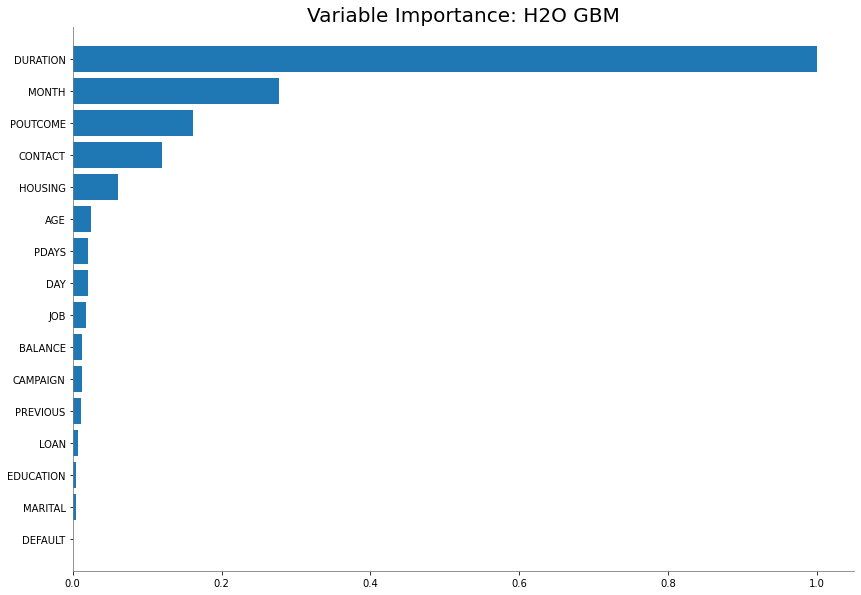

In [44]:
#look at important variable
model.varimp_plot(num_of_features=20)